In [ ]:
#base file path
# path = '/content/drive/Shareddrives/Soft Computing Project'
path = '/content/drive/Shareddrives/soft computing project test'

# imports

In [ ]:
from google.colab import drive           # For mounting Google Drive
import os                                 # For file and directory operations
import cv2                                # For image processing
import numpy as np                        # For numerical operations
import pandas as pd                       # For data manipulation and analysis
from sklearn.cluster import KMeans        # For clustering
import tensorflow as tf                   # For deep learning
from tensorflow.keras.applications import VGG16  # For using pre-trained VGG16 model
from tensorflow.keras.applications.vgg16 import preprocess_input  # For preprocessing inputs for VGG16
from tensorflow.keras.models import Model  # For loading models
import matplotlib.pyplot as plt           # For plotting images
from sklearn.utils import shuffle        # For shuffling data


# Mount Google Drive
drive.mount('/content/drive')
driveLocation = path
%cd $driveLocation

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
/content/drive/Shareddrives/soft computing project test


# basic functions

In [ ]:
#function to load images from a directory

def load_images_from_folder(folder_path):
    dataset = np.load(folder_path)
    return dataset['images'], dataset['image_files']



In [ ]:
#function to display images by cluster
def plot_images_by_cluster(images, image_files, clusters, num_clusters, num_images_to_display=10):
    for cluster_num in range(num_clusters):
        cluster_indices = np.where(clusters == cluster_num)[0]
        num_images = len(cluster_indices)

        # Create a figure to show images
        plt.figure(figsize=(15, 5))
        plt.suptitle(f'Cluster {cluster_num + 1} (Total images: {num_images})')

        # Randomly select images to display
        selected_indices = np.random.choice(cluster_indices, size=min(num_images_to_display, num_images), replace=False)

        # Display selected images in the cluster
        for i, idx in enumerate(selected_indices):
            plt.subplot(2, 5, i + 1)
            plt.imshow(cv2.cvtColor(images[idx], cv2.COLOR_BGR2RGB))  # Convert BGR (OpenCV) to RGB for display
            plt.title(f'Image: {image_files[idx]}')
            plt.axis('off')
        plt.show()

In [ ]:
#function to save cluster assignments to a CSV file
def save_cluster_assignments(image_files, clusters, output_file='cluster_assignments.csv'):
    data = {'Image File': image_files, 'Cluster': clusters}
    df = pd.DataFrame(data)
    df.to_csv(output_file, index=False)

In [ ]:
#function to load the clusters
def get_clusters(image_files, input_file='cluster_assignments.csv'):
    df = pd.read_csv(input_file)
    # map the clusters back to the provided image files
    cluster_dict = dict(zip(df['Image File'], df['Cluster']))

    # ensure clusters are returned in the same order as image_files
    clusters = [cluster_dict[img] for img in image_files]

    return clusters

In [ ]:
#function to extract features using VGG16
def extract_features_vgg16(images):
    model = VGG16(weights='imagenet', include_top=False, input_shape=(224, 224, 3))
    model = Model(inputs=model.inputs, outputs=model.layers[-1].output)  # Use the last convolutional layer

    #preprocess images
    images_preprocessed = preprocess_input(images)

    #extract features
    features = model.predict(images_preprocessed)

    #flatten features
    features = features.reshape(len(features), -1)

    return features


In [ ]:
def gs_images(images, target_size=(224, 224)):
    gs_images = []
    for image in images:
      img_resized = cv2.resize(image, target_size)
      gray_image = cv2.cvtColor(img_resized, cv2.COLOR_BGR2GRAY)

      # Merge the grayscale image back into a 3-channel image
      three_channel_gray = cv2.merge((gray_image, gray_image, gray_image))
      gs_images.append(three_channel_gray)
    return np.array(gs_images)

In [ ]:
#resize images for input into VGG-16
def resize_images(images, target_size=(224, 224)):
    resized_images = []
    for img in images:
        # Resize the image using OpenCV
        img_resized = cv2.resize(img, target_size)
        resized_images.append(img_resized)
    return np.array(resized_images)

In [ ]:
def perform_pca(features, num_components):
    # Standardize the data
    features_meaned = features - np.mean(features, axis=0)

    # Calculate SVD
    s, u, v = tf.linalg.svd(features_meaned, full_matrices=False)

    # Select the top components from the right singular vectors (v)
    principal_components = v[:, :num_components]

    # Compute the PCA features
    features_pca = tf.matmul(features_meaned, principal_components)

    return features_pca.numpy()

# Extract the features of the data (Full color)

In [ ]:
#load the image files
unlabeled_dataset_folder = os.path.join(path, 'dataset.npz')
images, image_files = load_images_from_folder(unlabeled_dataset_folder)

# Resize the images to the required input size for VGG16 (224x224)
resized_images = resize_images(images)

# extract features from the images using VGG16 convolution layers, the extract_features_vgg16 function normalizes the images
features = extract_features_vgg16(resized_images)

#specify the file path to save the features
features_file_path = os.path.join(path, 'features.npy')

#save the features variable to a .npy file
np.save(features_file_path, features)

del resized_images
del features

58889256/58889256 ━━━━━━━━━━━━━━━━━━━━ 4s 0us/step
125/125 ━━━━━━━━━━━━━━━━━━━━ 32s 121ms/step


# Extract the features of the data (Grayscale)


In [ ]:
#load the image files
unlabeled_dataset_folder = os.path.join(path, 'dataset.npz')
images, image_files = load_images_from_folder(unlabeled_dataset_folder)

images_gs = gs_images(images)

#extract features from the images using VGG16 convolution layers
features = extract_features_vgg16(images_gs)

#specify the file path to save the features
features_gray_file_path = os.path.join(path, 'features_gray.npy')


#save the features variable to a .npy file
np.save(features_gray_file_path, features)

del images_gs

 23/125 ━━━━━━━━━━━━━━━━━━━━ 12s 124ms/step

KeyboardInterrupt: 

# Cluster the data

## using Kmeans to cluster the data

### full color Kmeans

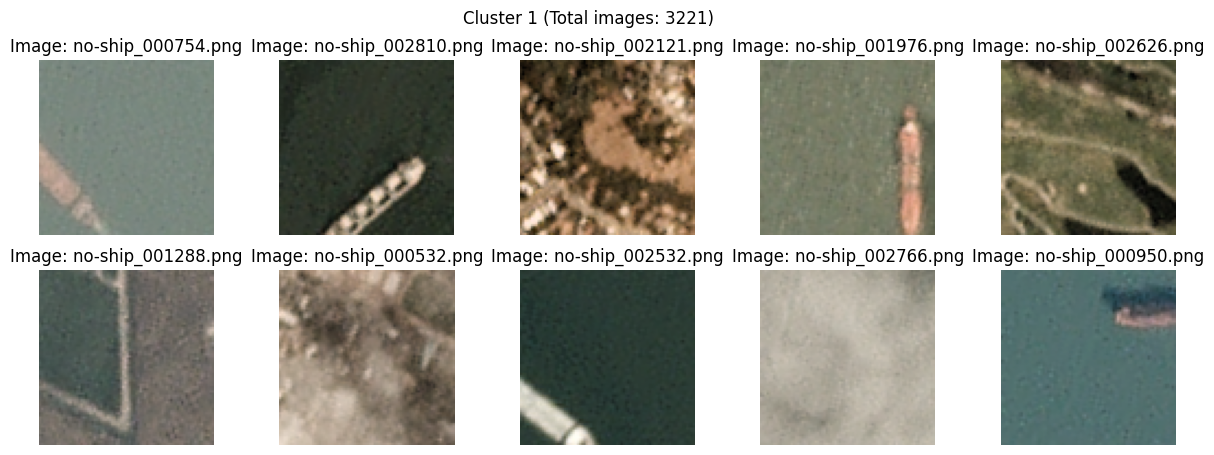

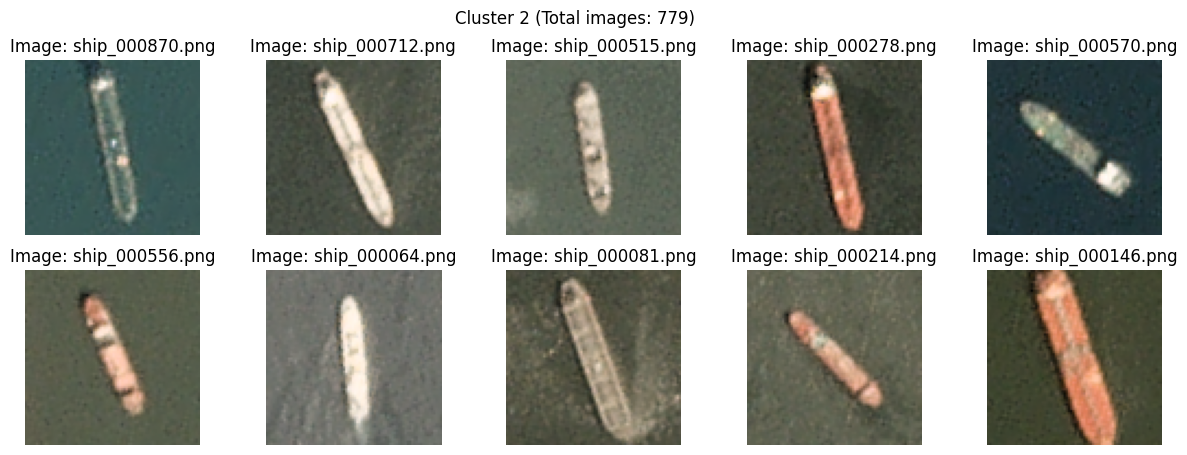

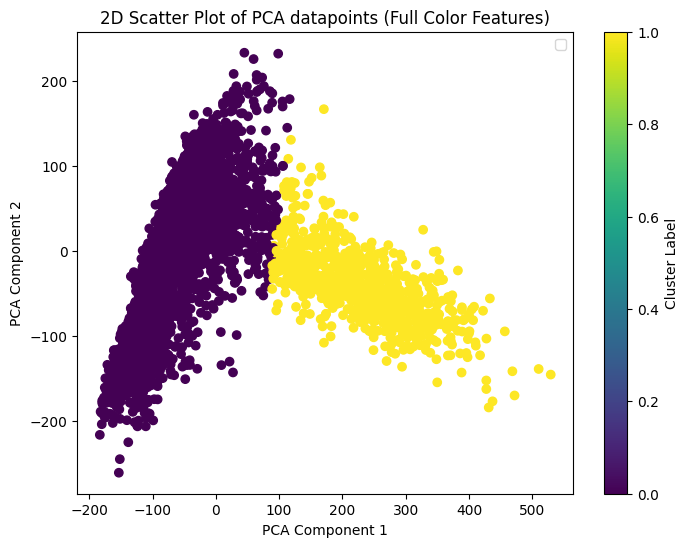

In [ ]:
#load images from the unlabeled dataset
unlabeled_dataset_folder = os.path.join(path, 'dataset.npz')
images, image_files = load_images_from_folder(unlabeled_dataset_folder)
#load the features of the data
features_file_path = os.path.join(path, 'features.npy')
features = np.load(features_file_path)


# Number of components for PCA
num_components = 2
features_pca = perform_pca(features, num_components)

num_clusters = 2
# Apply K-means clustering to the PCA-reduced features
kmeans = KMeans(n_clusters=num_clusters, random_state=42)
clusters_k = kmeans.fit_predict(features_pca)

# Save cluster assignments
save_cluster_assignments(image_files, clusters_k, output_file='cluster_assignments_kmeans.csv')

# Plot images for each cluster
plot_images_by_cluster(images, image_files, clusters_k, num_clusters, num_images_to_display=10)



In [ ]:
# Needs 3 components to display the scatter plot. Currently, we are using only 2 components.
# # Plotting the clusters in 3D
# fig = plt.figure()
# ax = fig.add_subplot(111, projection='3d')

# # Scatter plot of the PCA features, colored by cluster
# scatter = ax.scatter(features_pca[:, 0], features_pca[:, 1], features_pca[:, 2], c=clusters_k, cmap='viridis')

# # Add a color bar to indicate cluster colors
# cbar = plt.colorbar(scatter)
# cbar.set_label('Cluster Label')

# # Labels and title
# ax.set_xlabel('PCA Component 1')
# ax.set_ylabel('PCA Component 2')
# ax.set_zlabel('PCA Component 3')
# ax.set_title('3D Scatter Plot of Clusters')

# plt.show()

### grayscale kmeans

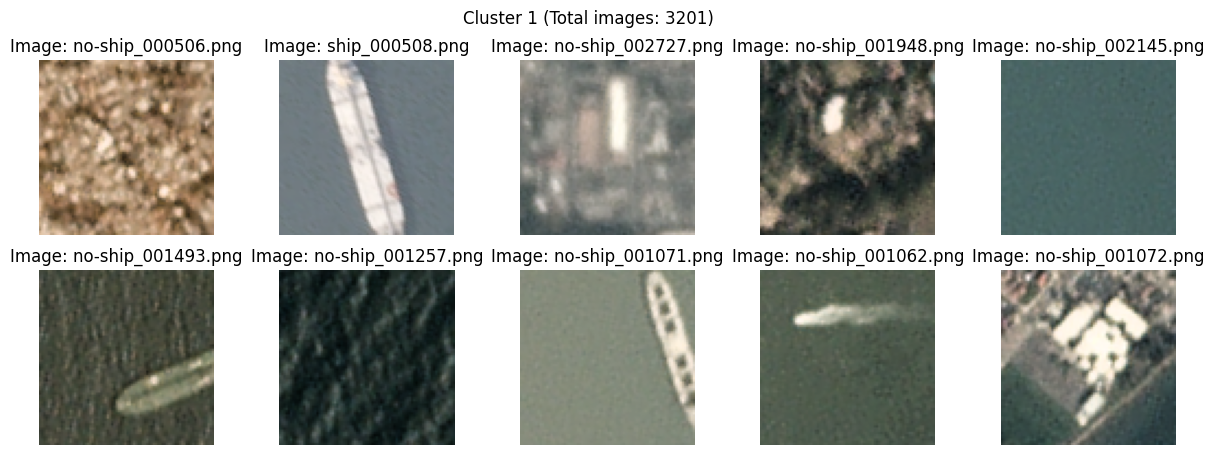

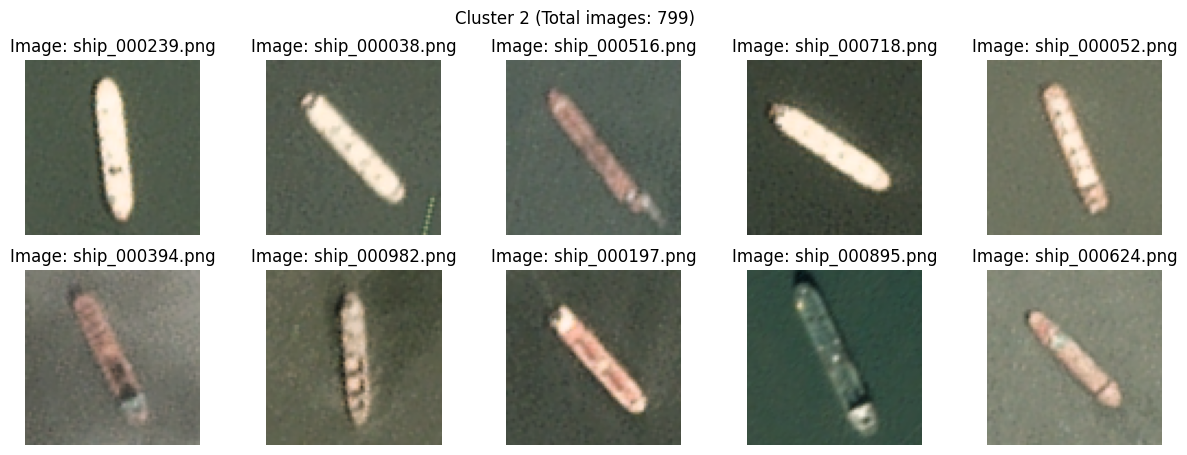

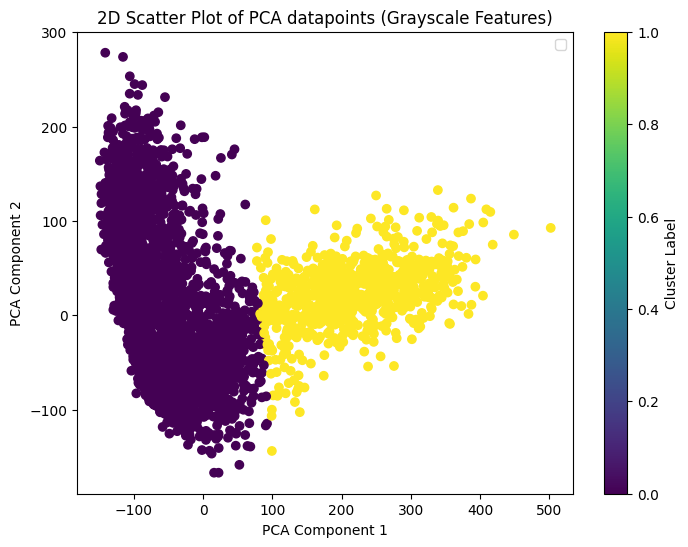

In [ ]:
#load images from the unlabeled dataset
unlabeled_dataset_folder = os.path.join(path, 'dataset.npz')
images, image_files = load_images_from_folder(unlabeled_dataset_folder)
#load the features of the data
features_file_path = os.path.join(path, 'features_gray.npy')
features_gray = np.load(features_file_path)


# Number of components for PCA
num_components = 2  # Change this based on your needs
features_pca = perform_pca(features_gray, num_components)

num_clusters = 2
# Apply K-means clustering to the PCA-reduced features
kmeans = KMeans(n_clusters=num_clusters, random_state=42)
clusters_k = kmeans.fit_predict(features_pca)

# Save cluster assignments
save_cluster_assignments(image_files, clusters_k, output_file='cluster_assignments_kmeans_gs.csv')

# Plot images for each cluster
plot_images_by_cluster(images, image_files, clusters_k, num_clusters, num_images_to_display=10)


## using c-means fuzzy clustering

Converged at iteration 73


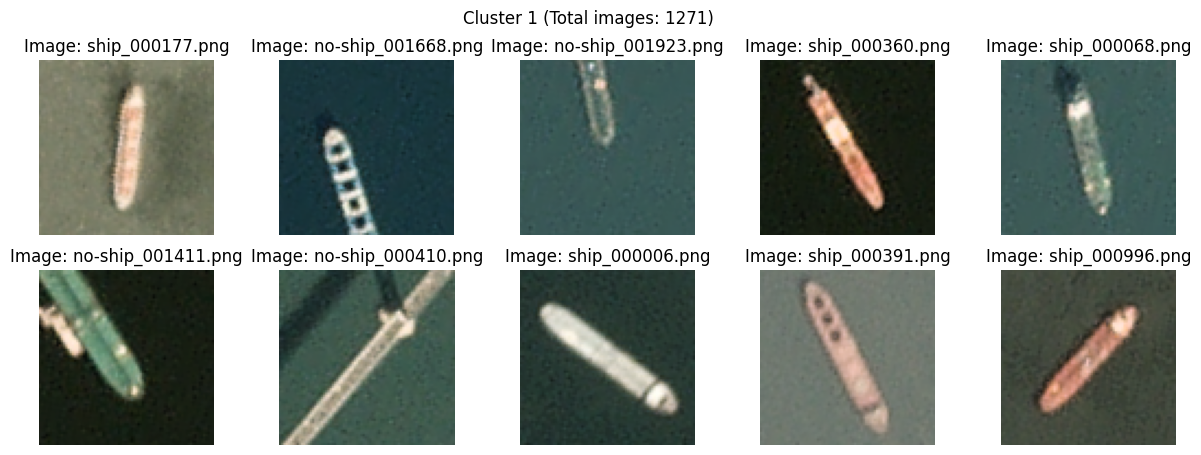

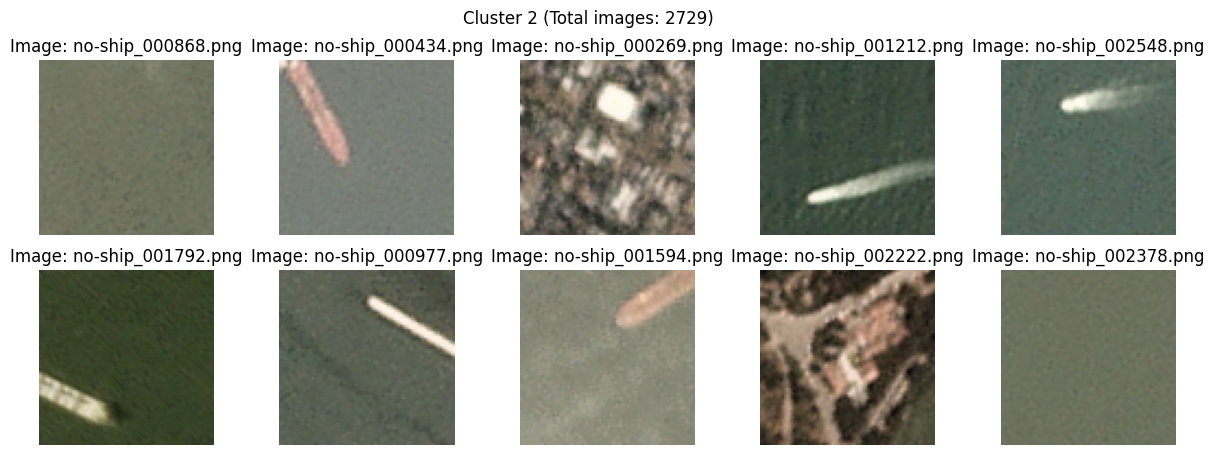

In [ ]:
#load images from the unlabeled dataset
unlabeled_dataset_folder = os.path.join(path, 'dataset.npz')
images, image_files = load_images_from_folder(unlabeled_dataset_folder)
#load the features of the data
features_file_path = os.path.join(path, 'features.npy')
features = np.load(features_file_path)


# Number of components for PCA
num_components = 2
features_pca = perform_pca(features, num_components)

# Fuzzy C-Means clustering
class FuzzyCMeans:
    def __init__(self, n_clusters=2, m=2, max_iter=100, epsilon=1e-5):
        self.n_clusters = n_clusters
        self.m = m
        self.max_iter = max_iter
        self.epsilon = epsilon

    def initialize_membership(self, n_samples):
        membership = np.random.dirichlet([1] * self.n_clusters, size=n_samples)
        return tf.convert_to_tensor(membership, dtype=tf.float32)

    def update_centers(self, data, membership):
        power = tf.pow(membership, self.m)
        num = tf.matmul(tf.transpose(power), data)
        denom = tf.reduce_sum(power, axis=0, keepdims=True)
        centers = num / denom
        return centers

    def update_membership(self, data, centers):
        dist = tf.norm(tf.expand_dims(data, axis=1) - tf.expand_dims(centers, axis=0), axis=2)
        dist = tf.pow(dist, 2 / (self.m - 1))
        denominator = tf.reduce_sum(tf.pow(1 / dist, 1), axis=1, keepdims=True)
        new_membership = tf.pow(1 / dist, 1) / denominator
        return new_membership

    def fit(self, data):
        n_samples = data.shape[0]
        membership = self.initialize_membership(n_samples)

        for i in range(self.max_iter):
            centers = self.update_centers(data, membership)
            new_membership = self.update_membership(data, centers)

            if tf.reduce_max(tf.abs(new_membership - membership)) < self.epsilon:
                print(f"Converged at iteration {i+1}")
                break

            membership = new_membership

        self.centers = centers
        self.membership = membership
        return centers, membership

# Initialize Fuzzy C-Means and fit to PCA-reduced features
fcm = FuzzyCMeans(n_clusters=num_clusters, m=2, max_iter=100, epsilon=1e-5)
centers_fcm, membership = fcm.fit(tf.convert_to_tensor(features_pca, dtype=tf.float32))

# Determine the cluster assignment with the highest membership
clusters_fcm = tf.argmax(membership, axis=1).numpy()

# Save cluster assignments
save_cluster_assignments(image_files, clusters_fcm, output_file='cluster_assignments_fcm.csv')

# Plot images for each cluster
plot_images_by_cluster(images, image_files, clusters_fcm, num_clusters, num_images_to_display=10)